In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft
import matplotlib.gridspec as gridspec

client = tt.startdask(nthreads=1,n_workers = 52)

client

<Client: 'tcp://127.0.0.1:44267' processes=52 threads=52, memory=416.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 52
Total threads: 52,Total memory: 416.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44267,Workers: 52
Dashboard: /proxy/8787/status,Total threads: 52
Started: Just now,Total memory: 416.00 GiB
Comm: tcp://127.0.0.1:41941,Total threads: 1
Dashboard: /proxy/34265/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:41645,


# Rather than timeseries, quantify the temporal variability as error bars instead. 

In [ ]:

data = {}
for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]:
# for expt in ["full-40","beamless-40","smooth-40"]:
    path = Path(f"/scratch/nm03/ab8992/april-manytimes") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc")
    times = os.listdir(path)
    times = np.sort(np.array([int(i.split("t0-")[1]) for i in times]))

    data[expt] = None
    for i in range(len(times)):
        try:
            newdata = xr.merge(
                        [
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam.nc",decode_times= False,decode_cf = False).rename({"EF":"EF_alongbeam"}).mean("time").load(),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam.nc",decode_times= False,decode_cf = False).rename({"EF":"EF_acrossbeam"}).mean("time").load(),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam_forward.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam_backward.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_alongbeam_xterm.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam_forward.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam_backward.nc",decode_times= False,decode_cf = False),
                            xr.open_dataset(path / f"t0-{times[i]}" / "EF_acrossbeam_xterm.nc",decode_times= False,decode_cf = False),
                            bathy.rename({"depth":"bathy"}) * -1
                        ]
                    ).expand_dims({"time":[float(times[i])]})
            if data[expt] is None:
                data[expt] = newdata
            else:
                data[expt] = xr.concat(
                    [
                        data[expt],
                        newdata
                    ],
                    dim = "time"
                )
        except Exception as e:
            print(f"Error processing time {times[i]} for experiment {expt}: {e}")

    data[expt].time.values[:] -= data[expt].time.values[0]
    data[expt].time.values[:] /= 24

## POINT IN KLYMAK CORRESPONDS TO:
xb,yb = 224,68

Error processing time 3960 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-3960/EF_alongbeam.nc'
Error processing time 4680 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-4680/EF_alongbeam.nc'
Error processing time 5400 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-5400/EF_alongbeam.nc'
Error processing time 6120 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-6120/EF_alongbeam.nc'
Error processing time 7560 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-7560/EF_alongbeam.nc'
Error processing time 8280 for experiment full-40: [Errno 2] No such file or directory: '/scratch/nm03/ab8992/april-manytimes/full-40/t0-8280/EF_alongbeam.nc'
Error processing time 9000 for experiment full

In [134]:
def contour_mask_singleline(xs,ys,data):
    """
    Returns umask,vmask
    """
    dx = (data.yb[1] - data.yb[0]).values
    if xs[0] == xs[1]: # HANDLE VERTICAL LINE
        return xr.where(
            (np.abs(data.xb - xs[0]) < dx) *
            (data.yb > ys[0]) * 
            (data.yb < ys[1])            
            ,1,0
        ).fillna(0), data * 0
    if ys[0] == ys[1]: # HANDLE HORIZONTAL LINE
        return data * 0,xr.where(
            (np.abs(data.yb - ys[0]) < dx) *
            (data.xb > xs[0]) * 
            (data.xb < xs[1])
            ,1,0
        ).fillna(0)
    
    ## Deal with an angled line
    m = (ys[1] - ys[0]) / (xs[1] - xs[0])
    c = ys[0] - m * xs[0]

    ## V mask first. So, we need unique points in x
    x_points = np.arange(xs[0],xs[1],dx)
    y_points = m * x_points + c
    # y_points = np.round(y_points,1)
    x_points = np.round(x_points,0)
    vmask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        vmask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )
    ## U mask second. So, we need unique points in y
    y_points = np.arange(np.min(ys),np.max(ys),dx)
    x_points = (y_points - c) / m
    umask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        umask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )

    return umask,vmask

def contour_mask_compound(xs,ys,data):
    umask,vmask = contour_mask_singleline(xs[0],ys[0],data)
    length = np.sqrt((xs[0][1] - xs[0][0])**2 + (ys[0][1] - ys[0][0])**2) * 1000
    for i in range(1,len(xs)):
        u,v = contour_mask_singleline(xs[i],ys[i],data)
        umask += u
        vmask += v
        length += np.sqrt((xs[i][1] - xs[i][0])**2 + (ys[i][1] - ys[i][0])**2) * 1000

    return xr.merge(
        [xr.where(umask == 0,0,1).rename("umask") , xr.where(vmask == 0,0,1).rename("vmask"),xr.DataArray(length).rename("length")])

def contour_integral(xs,ys,alongbeam,acrossbeam):
    """
    Pass x and y coords of straight line. Need to pre-multiply data to get orientation to line 
    correct as function just integrates along the line. If line is parallel to an axis, just 
    pre multiply alongbeam or acrossbeam by 0 to ensure that we don't integrate over empty dimension.
    """
    if type(xs[0]) == list:
        mask = contour_mask_compound(xs,ys,alongbeam)
        umask = mask["umask"]
        vmask = mask["vmask"]
        length = mask["length"]

    else:
        umask,vmask = contour_mask_singleline(xs,ys,alongbeam)
        length = np.sqrt((xs[1] - xs[0])**2 + (ys[1] - ys[0])**2) * 1000

    out = (umask * alongbeam).sum("xb").integrate("yb")
    out += (vmask * acrossbeam).sum("yb").integrate("xb")
    out = xr.Dataset({"energy":out,"length":length})
    out["energy"].attrs["Units"] = "kW"
    out["energy"].attrs["length"] = "m"
    return out # Convert km -> m

## Try timeseries just across the shelf like in other plot

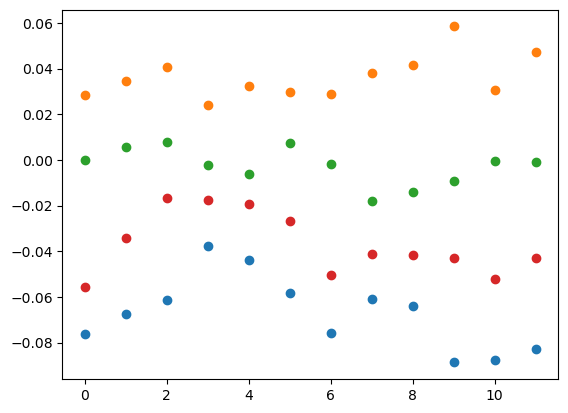

In [155]:
e = data["beamless-40"].isel(mode = slice(1,None)).sum("mode")
xs_reflect, ys_reflect = [[80 + 10, 210 + 10]],[ [120, -120]]
outf = [
    contour_integral(xs_reflect,ys_reflect,e.isel(time = i).EF_alongbeam_forward,e.isel(time = i).EF_acrossbeam_forward) for i in range(len(e.time))
]
outb = [
    contour_integral(xs_reflect,ys_reflect,e.isel(time = i).EF_alongbeam_backward,e.isel(time = i).EF_acrossbeam_backward) for i in range(len(e.time))
]
outc = [
    contour_integral(xs_reflect,ys_reflect,e.isel(time = i).EF_alongbeam_xterm,e.isel(time = i).EF_acrossbeam_xterm) for i in range(len(e.time))
]
outt = [
    contour_integral(xs_reflect,ys_reflect,e.isel(time = i).EF_alongbeam,e.isel(time = i).EF_acrossbeam) for i in range(len(e.time))
]
outf = np.array([i.energy / i.length for i in outf])
outb = np.array([i.energy / i.length for i in outb])
outc = np.array([i.energy / i.length for i in outc])
outt = np.array([i.energy / i.length for i in outt])
plt.scatter(np.arange(len(outf)),outf)
plt.scatter(np.arange(len(outb)),outb)
plt.scatter(np.arange(len(outb)),outc)
plt.scatter(np.arange(len(outb)),outt)


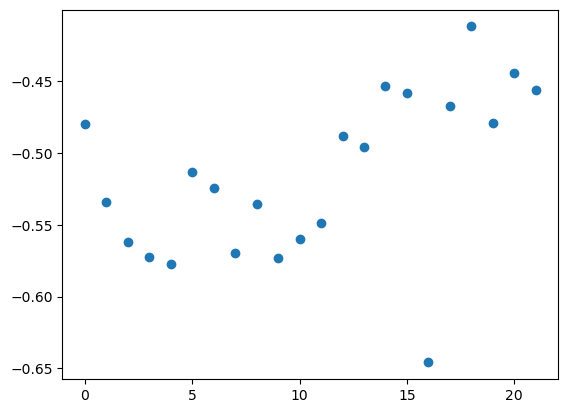

In [142]:
plt.scatter(np.arange(len(out)),out)

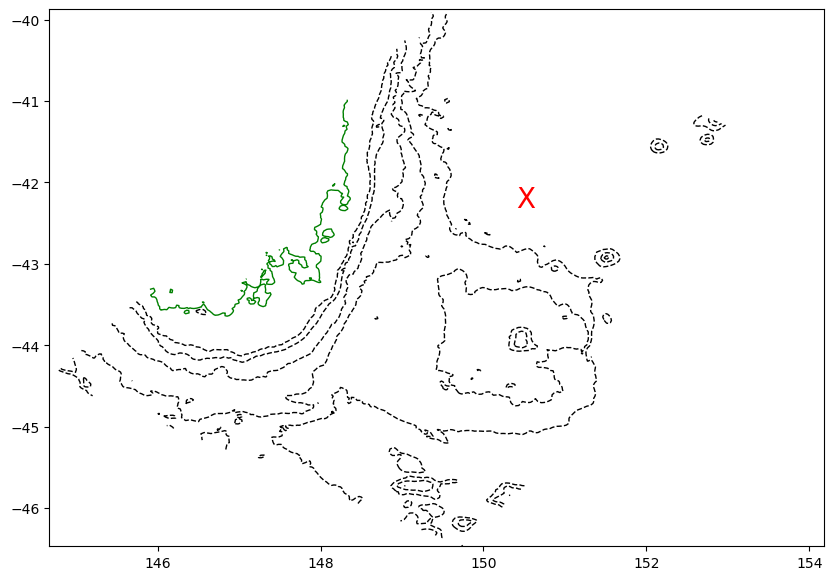

In [68]:
fig,ax = plt.subplots(1,1,figsize = (10,10))

# data["full-40"].EF_alongbeam.isel(mode = 0,time = 5).plot(ax = ax,add_colorbar = False)
data["full-40"].bathy.isel(time = 5).sel(xb = slice(0,450)).plot.contour(ax = ax,x = "lon",y = "lat",levels = [0,-3000, -2000, -4000,-1000,-250],colors = ["black","black","black","black","black","green"],linestyles = ["--","--","--","--","--","solid"],linewidths = 1)
# tt.plot_topo(ax,data["full-40"].bathy.isel(time = 0))
# ax.set_xlim(0,400)
ax.annotate("X",xy = (150.4,-42.3),color = "red",fontsize = 20)
ax.set_title("")
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_aspect("equal")

## CORRESPONDS TO:
xb,yb = 224,68

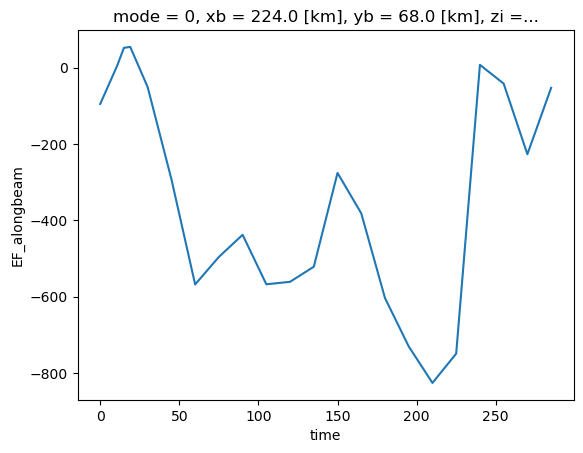

In [99]:
data["full-20"].sel(xb = xb,yb = yb).EF_alongbeam.isel(mode = 0).plot()

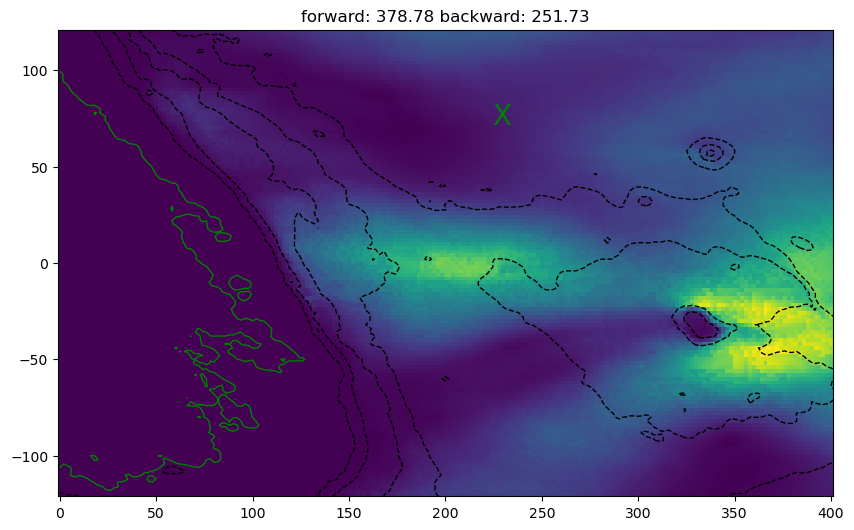

<Figure size 640x480 with 0 Axes>

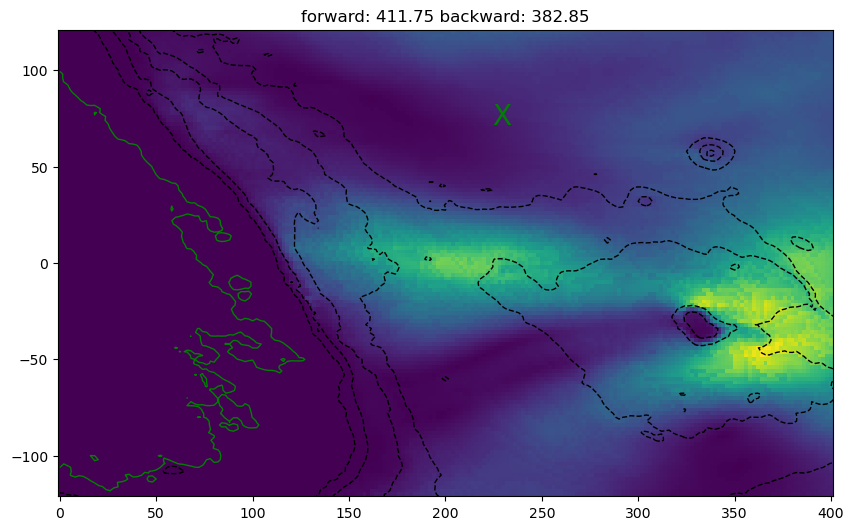

<Figure size 640x480 with 0 Axes>

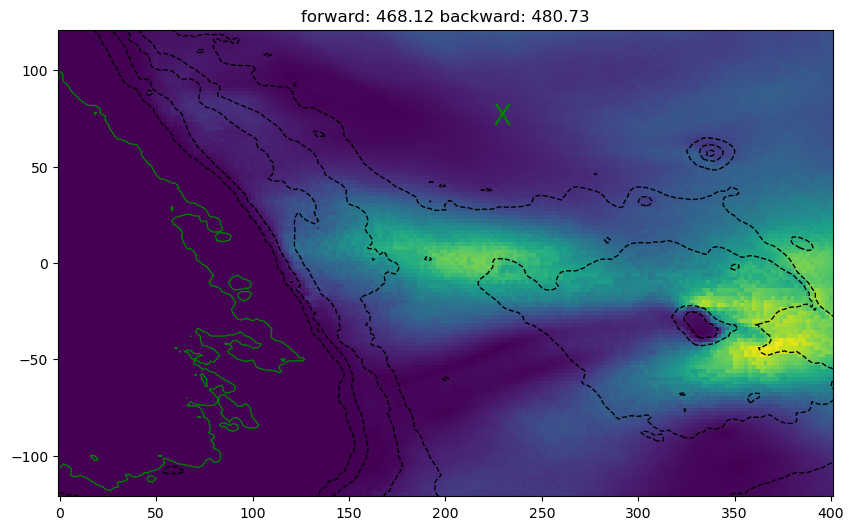

<Figure size 640x480 with 0 Axes>

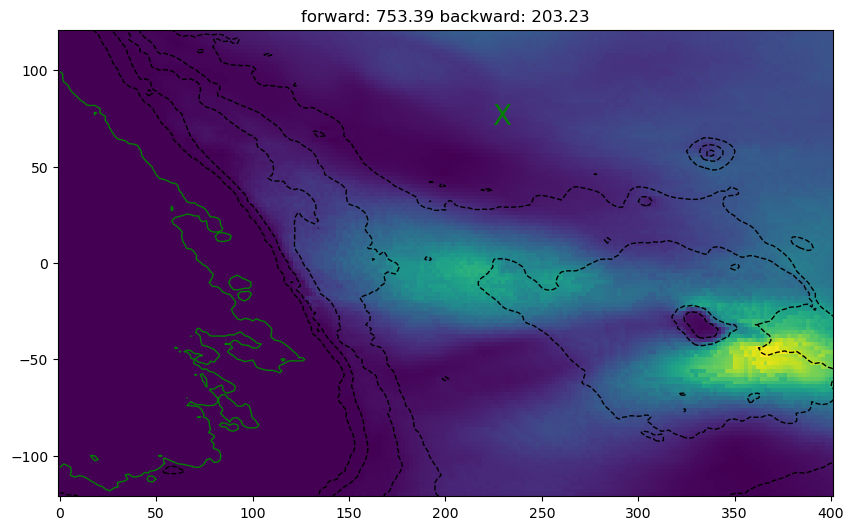

<Figure size 640x480 with 0 Axes>

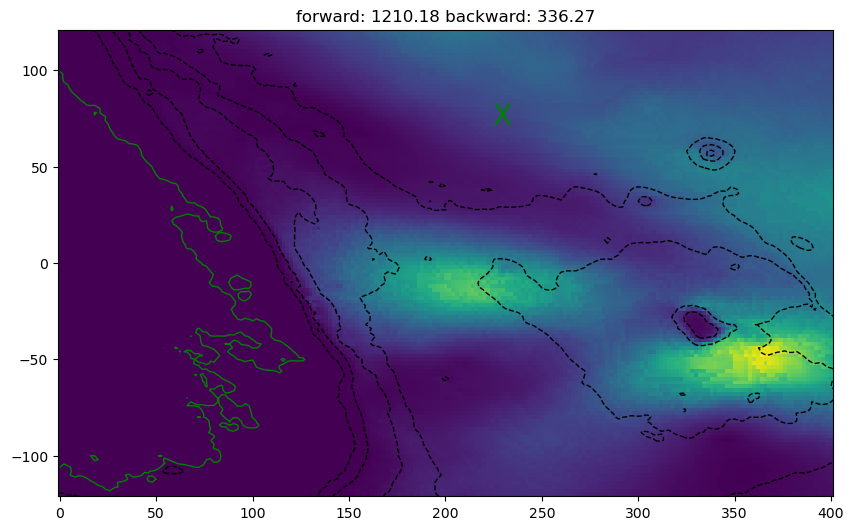

<Figure size 640x480 with 0 Axes>

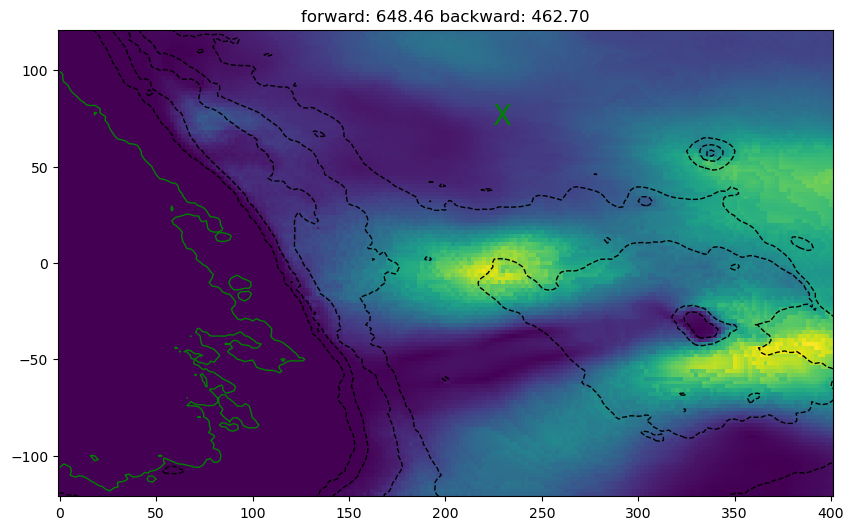

<Figure size 640x480 with 0 Axes>

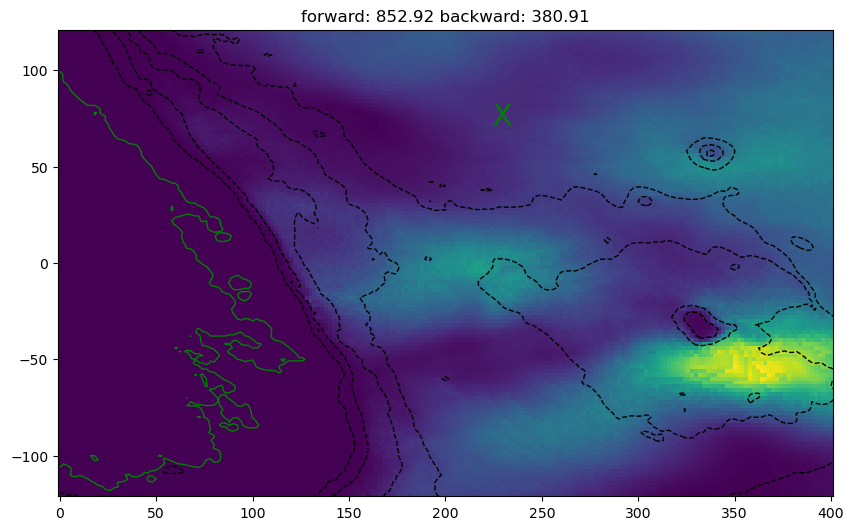

<Figure size 640x480 with 0 Axes>

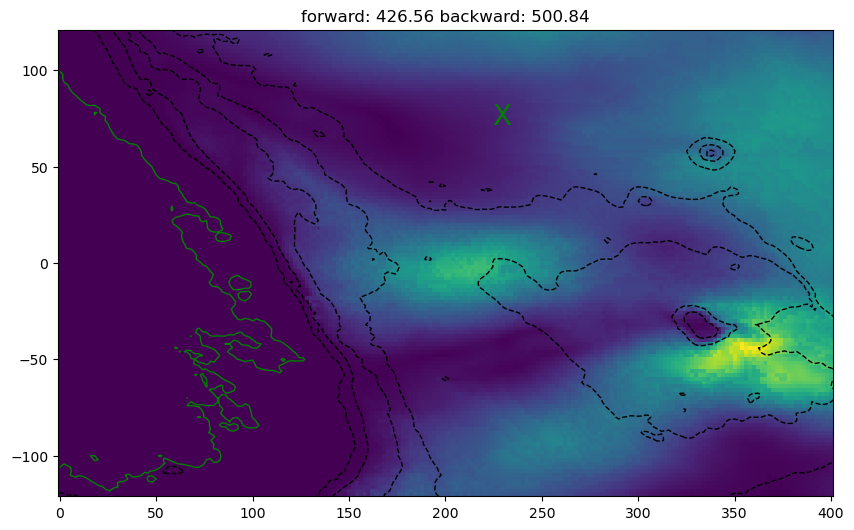

<Figure size 640x480 with 0 Axes>

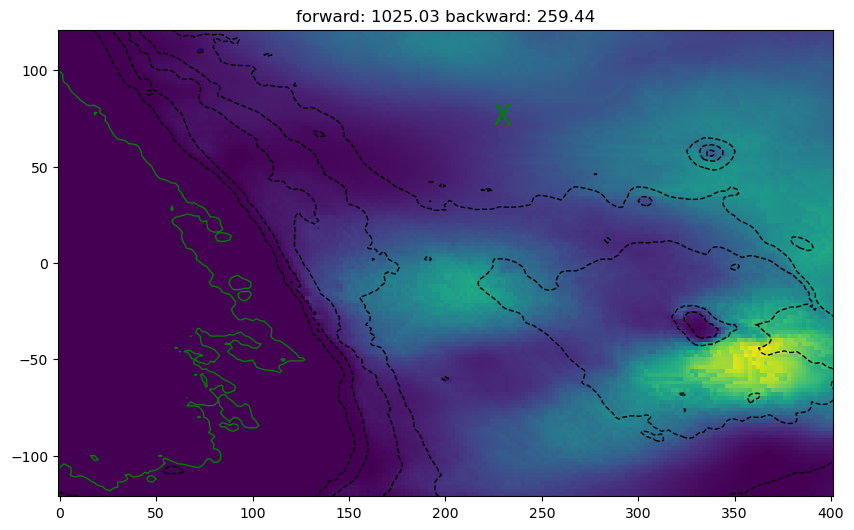

<Figure size 640x480 with 0 Axes>

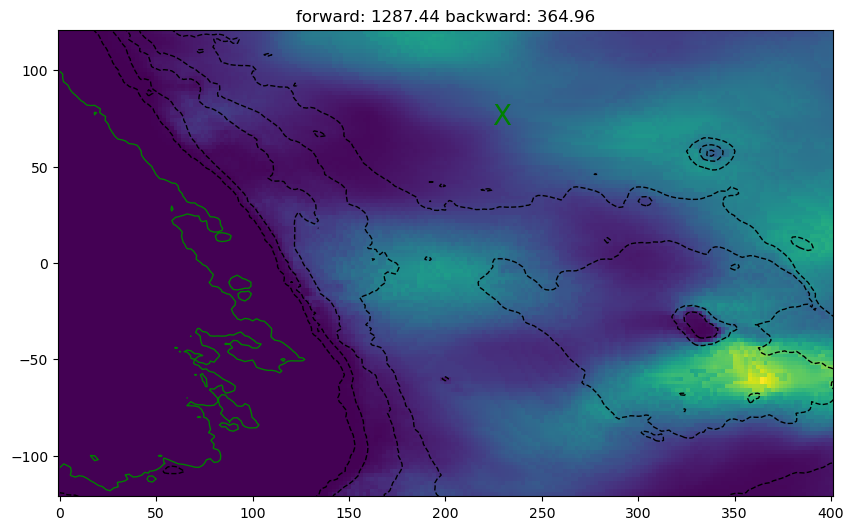

<Figure size 640x480 with 0 Axes>

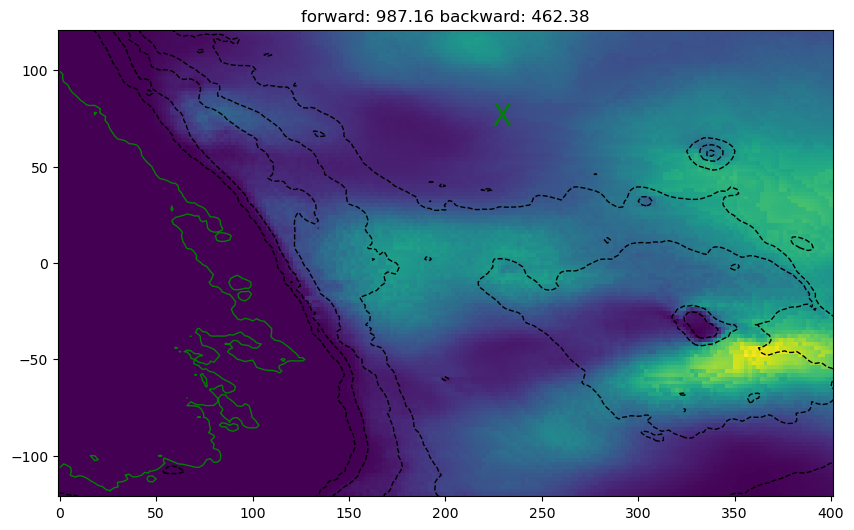

<Figure size 640x480 with 0 Axes>

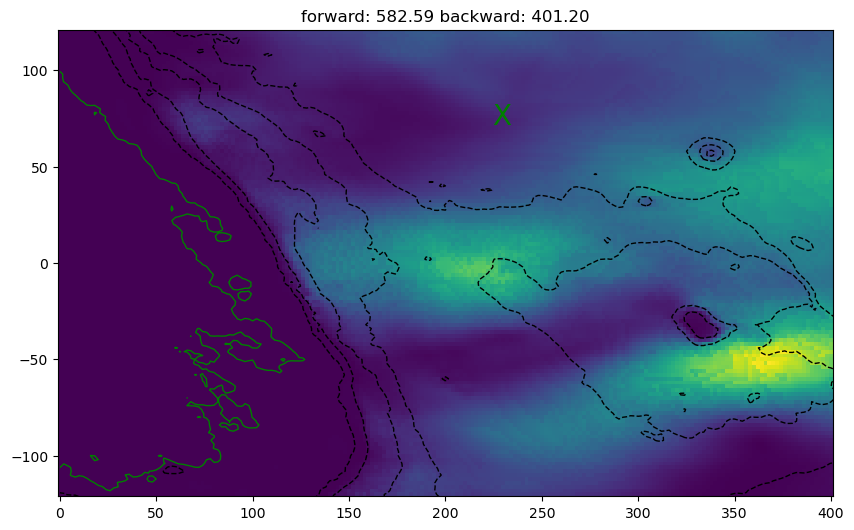

<Figure size 640x480 with 0 Axes>

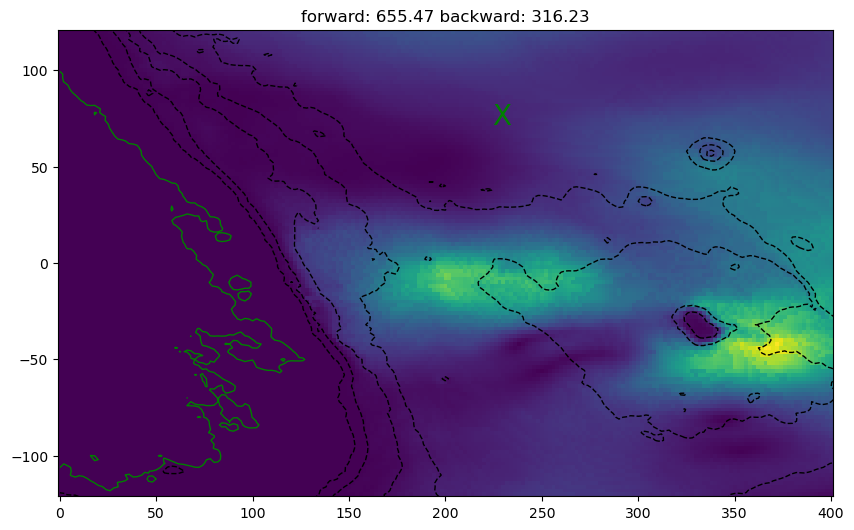

<Figure size 640x480 with 0 Axes>

In [133]:
expt = "full-40"
yb = 72
for i in range(len(data[expt].time)):
    fig,ax = plt.subplots(1,1,figsize = (10,10))
    forward = np.sqrt(data[expt].EF_alongbeam_forward**2 + data[expt].EF_acrossbeam_forward**2).isel(mode = 0,time = i).sel(xb = slice(0,400),yb = slice(-120,120))
    backward = np.sqrt(data[expt].EF_alongbeam_backward**2 + data[expt].EF_acrossbeam_backward**2).isel(mode = 0,time = i).sel(xb = slice(0,400),yb = slice(-120,120))
    forward.plot(ax = ax,add_colorbar = False)
    ax.annotate(f"X",xy = (xb,yb),color = "green",fontsize = 20)
    (-1 * data[expt].bathy).isel(time = 0).plot.contour(ax = ax,levels = [0,250, 1000, 2000,3000,4000],colors = ["green","black","black","black","black","black"],linestyles = ["solid","--","--","--","--","--"],linewidths = 1)
    f = forward.sel(xb = xb,yb = yb).values
    b = backward.sel(xb = xb,yb = yb).values
    ax.set_title(f"forward: {f:>.2f} backward: {b:>.2f}")
    ax.set_aspect("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.figure()